In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import scanpy as sc
import numpy as np
import pandas as pd
import sys, os

os.chdir('/ix/djishnu/alw399')

In [5]:
import celloracle as co
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams['figure.dpi'] = 180

sc.settings.set_figure_params(dpi=50, facecolor="white")

In [6]:
adata = sc.read_h5ad('/ix/djishnu/alw399/SpaceOracle/notebooks/.cache/adata_train.h5ad')
adata

AnnData object with n_obs × n_vars = 11567 × 5013
    obs: 'cluster', 'rctd_cluster', 'rctd_celltypes'
    uns: 'log1p'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

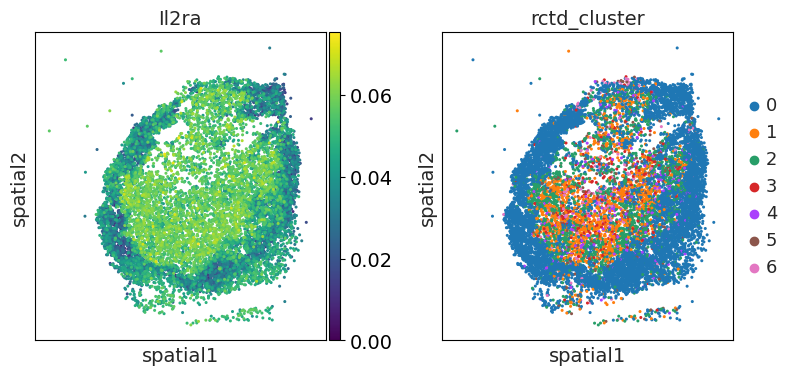

In [7]:
goi = 'Il2ra'
annot = 'rctd_cluster'

x = adata.obsm['spatial'][:, 0]
y = adata.obsm['spatial'][:, 1] * -1

adata = adata.copy()
adata.obsm['spatial'] = np.vstack([x, y]).T
sc.pl.spatial(adata, color=[goi, annot], layer='imputed_count', use_raw=False, cmap='viridis', spot_size=50)

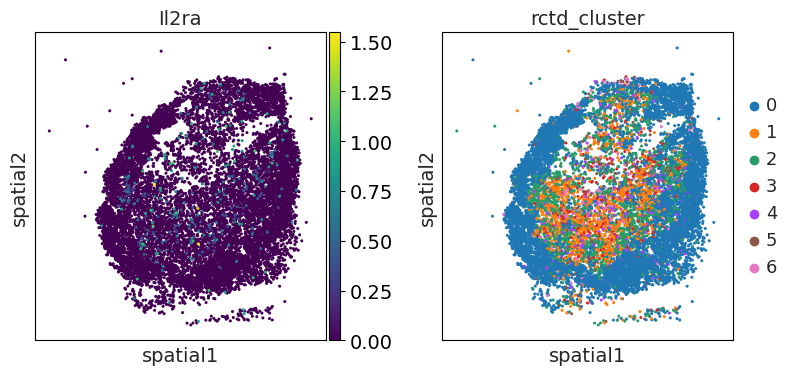

In [8]:
sc.pl.spatial(adata, color=[goi, annot], layer='normalized_count', use_raw=False, cmap='viridis', spot_size=50)


In [9]:
adata = sc.read_h5ad('/ix/djishnu/alw399/SpaceOracle/data/slideseq/day3_1.h5ad')
adata.obs['clusters'] = adata.obs['rctd_cluster']

2024-11-13 23:37:22.692829: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-13 23:37:22.715450: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-13 23:37:22.716285: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-13 23:37:23.961716: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


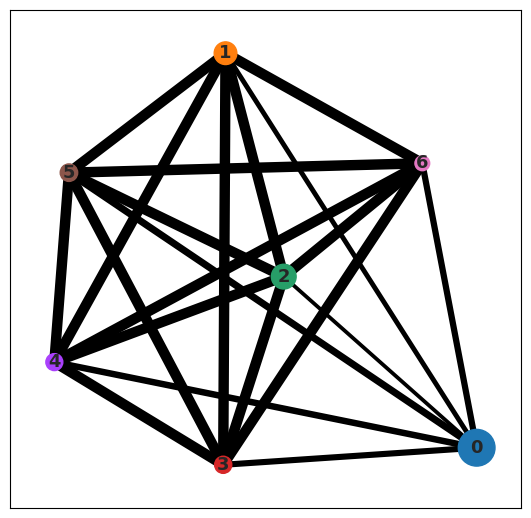

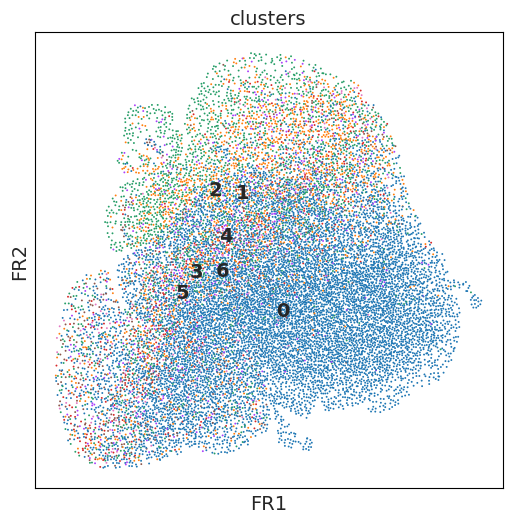

CPU times: user 2min 38s, sys: 733 ms, total: 2min 39s
Wall time: 3min 5s


In [10]:
%%time

sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_diffmap')
sc.tl.paga(adata, groups='clusters', neighbors_key='neighbors')
plt.rcParams["figure.figsize"] = [6, 6]
sc.pl.paga(adata)

sc.tl.draw_graph(adata, init_pos='paga', random_state=123)
sc.pl.draw_graph(adata, color='clusters', legend_loc='on data')

In [12]:
oracle = co.Oracle()
# adata.X = adata.layers["raw_count"].copy()

# Instantiate Oracle object.
oracle.import_anndata_as_raw_count(adata=adata,
                                   cluster_column_name="rctd_cluster",
                                   embedding_name="X_draw_graph_fr")

24649 genes were found in the adata. Note that Celloracle is intended to use around 1000-3000 genes, so the behavior with this number of genes may differ from what is expected.


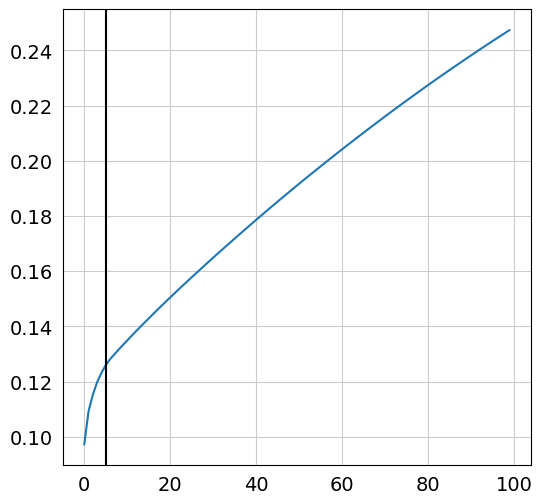

5


In [13]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

In [14]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=1)

cell number is :15920
Auto-selected k is :398


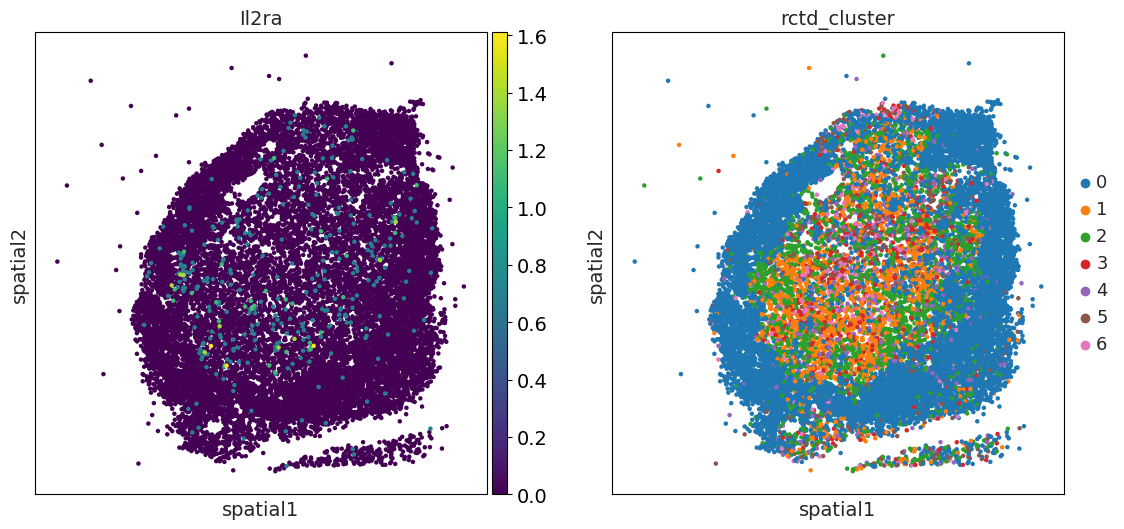

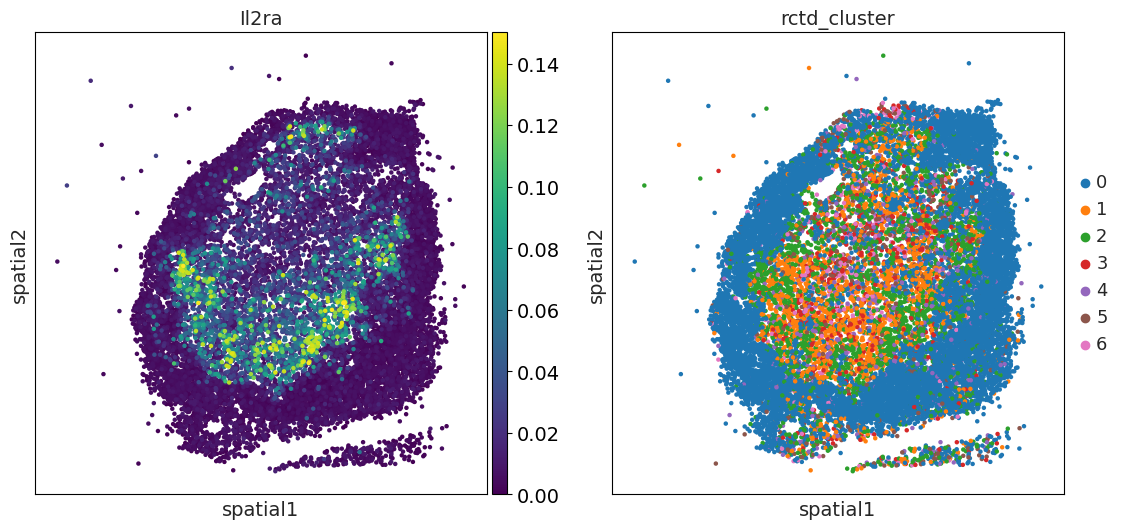

In [15]:
annot = 'rctd_cluster'

adata = oracle.adata
x = adata.obsm['spatial'][:, 0]
y = adata.obsm['spatial'][:, 1] * -1

adata = adata.copy()
adata.obsm['spatial'] = np.vstack([x, y]).T

sc.pl.spatial(adata, color=[goi, annot], layer='normalized_count', use_raw=False, cmap='viridis', spot_size=50)
sc.pl.spatial(adata, color=[goi, annot], layer='imputed_count', use_raw=False, cmap='viridis', spot_size=50)


In [16]:
co_imputed_count = adata.layers['imputed_count'].copy()
print(co_imputed_count)

[[0.          0.001737211 0.          ... 0.          0.
  0.         ]
 [0.          0.005211633 0.          ... 0.          0.
  0.         ]
 [0.          0.001737211 0.          ... 0.          0.
  0.         ]
 ...
 [0.          0.001737211 0.          ... 0.          0.
  0.         ]
 [0.          0.005211633 0.          ... 0.          0.
  0.         ]
 [0.          0.001737211 0.          ... 0.          0.
  0.         ]]


In [17]:
del adata.layers['imputed_count']

In [ ]:
sys.path.append('/ix/djishnu/alw399/SpaceOracle/src')

from spaceoracle.oracles import SpaceOracle

so = SpaceOracle(
    adata=adata,
    save_dir='/ix/djishnu/shared/djishnu_kor11/models',
    annot='rctd_cluster'
)

In [ ]:
so_imputed_count = so.adata.layer['imputed_count']
so_imputed_count.shape

In [ ]:
np.allclose(co_imputed_count, so_imputed_count)

In [ ]:
nsamples = 10
npcs = 2
space = np.random.rand(nsamples, npcs)
n_jobs = 1
b_sight = 1
metric = 'euclidean'
b_maxl = 3

In [ ]:
from spaceoracle.tools.utils import prune_neighbors

nn = NearestNeighbors(n_neighbors=b_sight + 1, metric=metric, n_jobs=n_jobs, leaf_size=30)
nn.fit(space)

dist, dsi = nn.kneighbors(space, return_distance=True)
knn = prune_neighbors(dsi, dist, b_maxl)

In [ ]:
from celloracle.trajecotyr.neighbors import BalancedKNN

bknn = BalancedKNN(k=k, sight_k=b_sight, maxl=b_maxl,
                    metric=metric, mode="distance", n_jobs=n_jobs)
bknn.fit(space)
knn = bknn.kneighbors_graph(mode="distance")